# Generic Imports

In [2]:
import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt 

# Setting Up the Environment

In [12]:
from text_snake_simple import TextSnakeEnvSimple

env = TextSnakeEnvSimple(screen_size=(15, 10), colab=True)    
num_runs = 50
x_list = list(range(num_runs+1))
for i, elem in enumerate(x_list):
    x_list[i] = elem*100

# Running the Algorithms

## Expected Sarsa

Text Snake!
Score: 19
----------------
[              ]
[              ]
[              ]
[              ]
[ @     -*--|  ]
[       ||---  ]
[       |---   ]
[    ------|   ]
[              ]
^^^^^^^^^^^^^^^^
Player Action (Right)


100%|██████████| 5/5 [01:36<00:00, 19.35s/it]


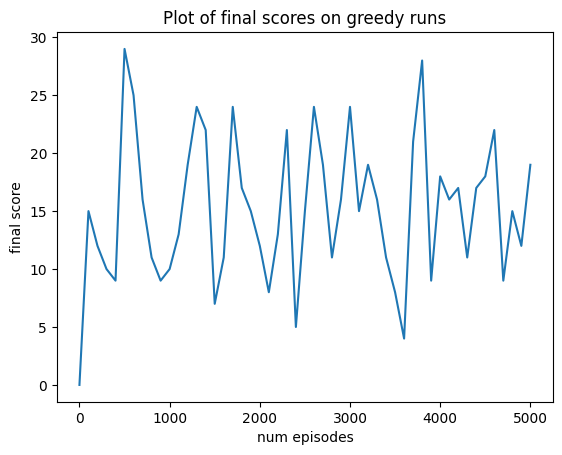

In [13]:
from exp_sarsa_functions.exp_sarsa_utils import create_state_dict, run_episode
from exp_sarsa_functions.exp_sarsa_ag import ExpectedSarsaAgent

state_dict = create_state_dict(n_bools=11)
agent_info = {"num_actions": 3, "num_states": len(state_dict), "EPS_START": 0.9, "EPS_END": 0.05, 
            "EPS_DECAY": 5000, "step_size": 0.8, "discount": 0.99, "seed": 0}
esarsa_agent = ExpectedSarsaAgent()
esarsa_agent.agent_init(agent_info)
esarsa_score_list = [0]
num_episodes = 1000
for run in tqdm.tqdm(range(num_runs//10)):
    steps_done = 0
    for episode in tqdm.tqdm(range(num_episodes)):
        if episode+1 == num_episodes and run+1 == num_runs//10: 
            steps_done, converged, score = run_episode(env, esarsa_agent, episode, state_dict, steps_done, False, True)
            esarsa_score_list.append(score)
        elif (episode+1)%100 == 0:
            steps_done, converged, score = run_episode(env, esarsa_agent, episode, state_dict, steps_done, False, False)
            esarsa_score_list.append(score)
        else: 
            steps_done, converged, _ = run_episode(env, esarsa_agent, episode, state_dict, steps_done, True, False)
plt.plot(x_list, esarsa_score_list)
plt.title("Plot of final scores on greedy runs")
plt.xlabel("num episodes")
plt.ylabel("final score")
plt.show()

## DQN

Text Snake!
Score: 20
----------------
[              ]
[  @           ]
[     -----|   ]
[     ||----   ]
[     |*----|- ]
[          |-  ]
[              ]
[              ]
[              ]
^^^^^^^^^^^^^^^^
Player Action (Left)


100%|██████████| 50/50 [16:22<00:00, 19.65s/it]


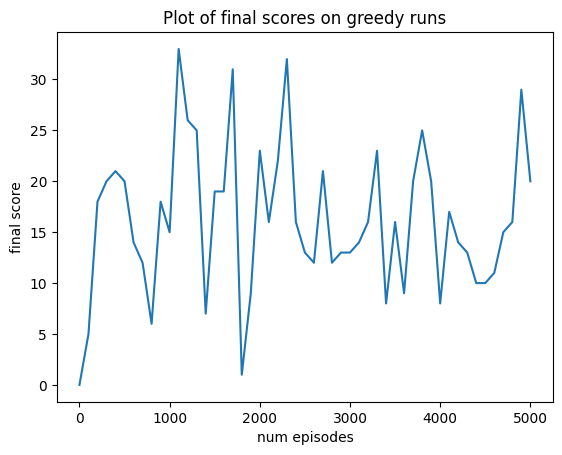

In [14]:
from dqn_functions.dqn_trainer import QTrainer

qtrainer = QTrainer()
dqn_score_list = [0]
for j in tqdm.tqdm(range(num_runs)):
    qtrainer.train(env, 100)
    obs, info = env.reset()
    done = False
    n_steps = 0
    while not done and n_steps < 5000:
        prediction = qtrainer.model(torch.tensor(obs, dtype=torch.float))
        action = qtrainer.argmax(prediction).item()
        obs, reward, done, _, info = env.step(action)
        n_steps += 1
        if j+1 == num_runs:
            env.render() 
        if done:
            break
    dqn_score_list.append(info["score"])
    env.close()
plt.plot(x_list, dqn_score_list)
plt.title("Plot of final scores on greedy runs")
plt.xlabel("num episodes")
plt.ylabel("final score")
plt.show()

## Policy Estimator

Text Snake!
Score: 1
-----------*----
[          |   ]
[          |   ]
[          |   ]
[              ]
[              ]
[          @   ]
[              ]
[              ]
[              ]
^^^^^^^^^^^^^^^^
Player Action (Straight)


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]


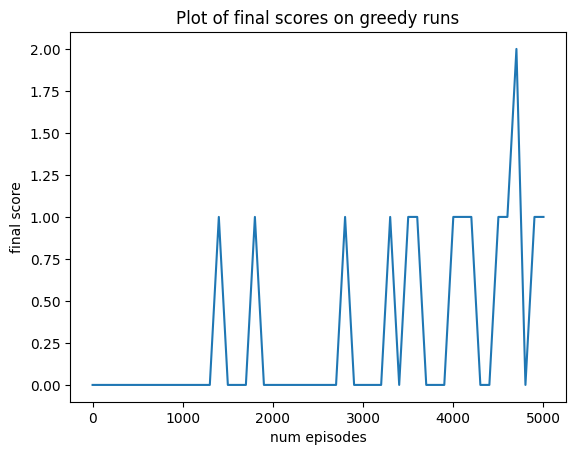

In [28]:
from policy_estimator_functions.policy_estimator import policy_estimator, reinforce, make_greedy_run

state, info = env.reset()
reinf_score_list = [0]
neural_agent = policy_estimator(11, 3)    
optimizer = optim.Adam(neural_agent.network.parameters(), lr=0.0001)
render = False 
for j in tqdm.tqdm(range(num_runs)): 
    num_episodes = 100
    total_rewards, converged = reinforce(env, neural_agent, optimizer, num_episodes=num_episodes)
    if j+1 == num_runs:
        render = True
    converged, score = make_greedy_run(env, neural_agent, render)
    reinf_score_list.append(score)
    env.close()
plt.plot(x_list, reinf_score_list)
plt.title("Plot of final scores on greedy runs")
plt.xlabel("num episodes")
plt.ylabel("final score")
plt.show()

## PPO

Text Snake!
Score: 0
----------------
[              ]
[              ]
[              ]
[              ]
[    --o       ]
[              ]
[        @     ]
[              ]
[              ]
^^^^^^^^^^^^^^^^
Game initialized!

100%|██████████| 50/50 [05:35<00:00,  6.72s/it]


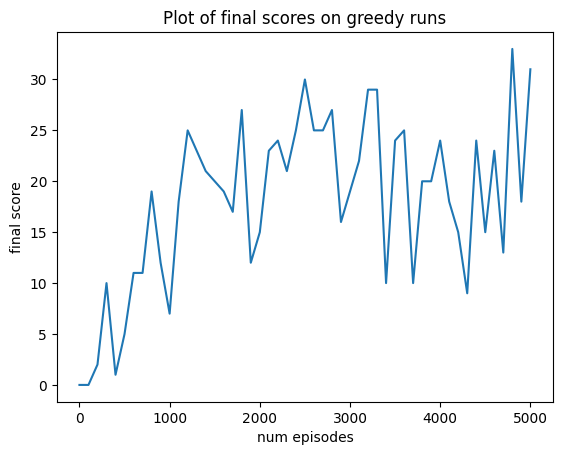

In [16]:
from stable_baselines3 import PPO

policy_kwargs = dict(activation_fn=nn.ReLU,
                net_arch=dict(pi=[256, 256], vf=[256, 256]))
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, ent_coef=0.01)
ppo_score_list = [0]
for j in tqdm.tqdm(range(num_runs)):
    model.learn(total_timesteps=100)
    vec_env = model.get_env() 
    obs = vec_env.reset()
    done = False 
    n_step = 0
    while not done and n_step < 5000: 
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        if j+1 == num_runs:
            env.render()
        n_step += 1
        if done: 
            break
    ppo_score_list.append(info[0]["score"])
plt.plot(x_list, ppo_score_list)
plt.title("Plot of final scores on greedy runs")
plt.xlabel("num episodes")
plt.ylabel("final score")
plt.show()

# General results

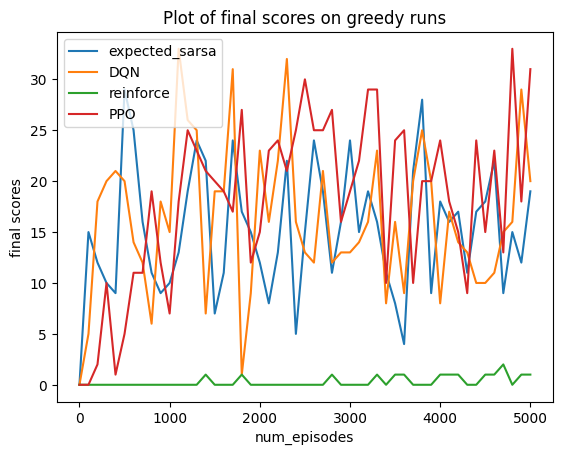

In [29]:
fig = plt.figure()
plt.plot(x_list, esarsa_score_list, label="expected_sarsa")
plt.plot(x_list, dqn_score_list, label="DQN")
plt.plot(x_list, reinf_score_list[0:51], label="reinforce")
plt.plot(x_list, ppo_score_list, label="PPO")
plt.xlabel("num_episodes")
plt.ylabel("final scores")
plt.legend()
plt.title("Plot of final scores on greedy runs")
plt.show()

Sarsa :
mean : 15.137254901960784
std : 6.240348179838463
DQN :
mean : 16.19607843137255
std : 7.268032632479693
REINFORCE :
mean : 0.29411764705882354
std : 0.49681801801254616
PPO :
mean : 18.07843137254902
std : 8.210092156954296


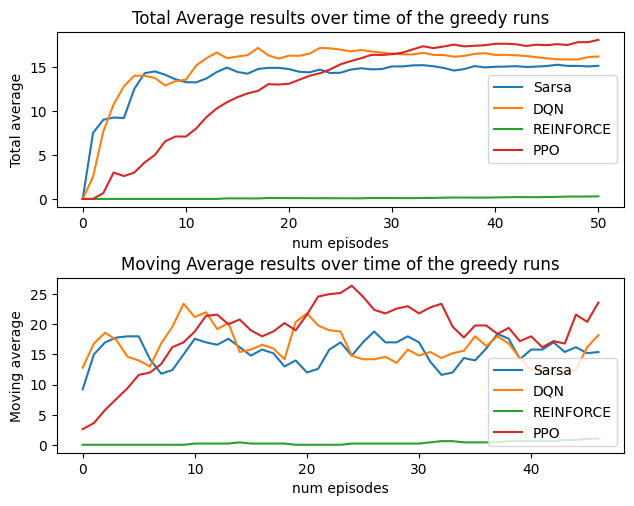

In [34]:
import numpy as np

res={'Sarsa' : esarsa_score_list, 'DQN' : dqn_score_list , 'REINFORCE' : reinf_score_list, 'PPO' : ppo_score_list}

for k in res.keys():
    print(k + ' :')
    print("mean : "+str(np.mean(res[k])))
    print("std : "+str(np.std(res[k])))
    

fig,axs=plt.subplots(2)
fig.tight_layout(h_pad=3)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

for key in res.keys():
    axs[0].plot(np.cumsum(res[key])/(np.arange(len(res[key]))+1),label = key)
    axs[1].plot(moving_average(res[key],5),label = key)

    
axs[0].set_ylabel('Total average')
axs[0].set_title('Total Average results over time of the greedy runs')
axs[1].set_ylabel('Moving average')
axs[1].set_title('Moving Average results over time of the greedy runs')

for i in [0,1]:
    axs[i].set_xlabel("num episodes")
    axs[i].legend()

## Longer run for Reinforce

Text Snake!
Score: 22
----------------
[|--------     ]
[--------*  @  ]
[        |     ]
[        |     ]
[        |     ]
[        |     ]
[       -|     ]
[              ]
[              ]
^^^^^^^^^^^^^^^^
Player Action (Straight)


100%|██████████| 100/100 [34:31<00:00, 20.72s/it]


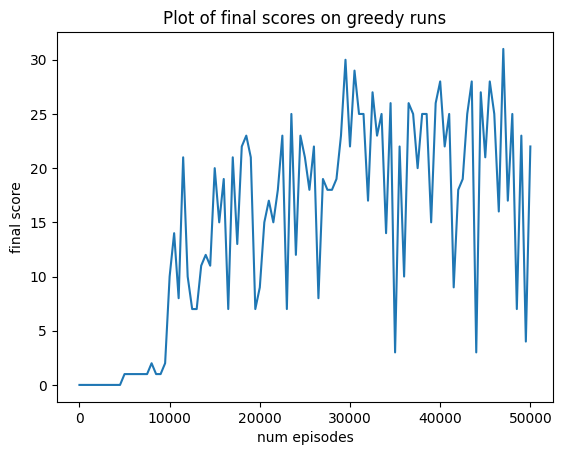

In [22]:
state, info = env.reset()
reinf_score_list = [0]
neural_agent = policy_estimator(11, 3)    
optimizer = optim.Adam(neural_agent.network.parameters(), lr=0.0001)
render = False 
longer_x_list = [500*i for i in range(101)]
for j in tqdm.tqdm(range(100)): 
    num_episodes = 500
    total_rewards, converged = reinforce(env, neural_agent, optimizer, num_episodes=num_episodes)
    if j+1 == 100:
        render = True
    converged, score = make_greedy_run(env, neural_agent, render)
    reinf_score_list.append(score)
    env.close()
plt.plot(longer_x_list, reinf_score_list)
plt.title("Plot of final scores on greedy runs")
plt.xlabel("num episodes")
plt.ylabel("final score")
plt.show()

# Smaller Screen Comparison

In [35]:
from text_snake_simple import TextSnakeEnvSimple

small_env = TextSnakeEnvSimple(screen_size=(12, 8), colab=True)    
num_runs = 50
x_list = list(range(num_runs+1))
for i, elem in enumerate(x_list):
    x_list[i] = elem*100

In [42]:
from exp_sarsa_functions.exp_sarsa_utils import create_state_dict, run_episode
from exp_sarsa_functions.exp_sarsa_ag import ExpectedSarsaAgent
from dqn_functions.dqn_trainer import QTrainer
from policy_estimator_functions.policy_estimator import policy_estimator, reinforce, make_greedy_run
from stable_baselines3 import PPO

state_dict = create_state_dict(n_bools=11)
agent_info = {"num_actions": 3, "num_states": len(state_dict), "EPS_START": 0.9, "EPS_END": 0.05, 
            "EPS_DECAY": 5000, "step_size": 0.8, "discount": 0.99, "seed": 0}
small_esarsa_agent = ExpectedSarsaAgent()
small_esarsa_agent.agent_init(agent_info)
small_esarsa_score_list = [0]
num_episodes = 1000
for run in tqdm.tqdm(range(num_runs//10)):
    steps_done = 0
    for episode in tqdm.tqdm(range(num_episodes)):
        if episode+1 == num_episodes and run+1 == num_runs//10: 
            steps_done, converged, score = run_episode(small_env, small_esarsa_agent, episode, state_dict, steps_done, False, True)
            small_esarsa_score_list.append(score)
        elif (episode+1)%100 == 0:
            steps_done, converged, score = run_episode(small_env, small_esarsa_agent, episode, state_dict, steps_done, False, False)
            small_esarsa_score_list.append(score)
        else: 
            steps_done, converged, _ = run_episode(small_env, small_esarsa_agent, episode, state_dict, steps_done, True, False)

small_qtrainer = QTrainer()
small_dqn_score_list = [0]
for j in tqdm.tqdm(range(num_runs)):
    small_qtrainer.train(small_env, 100)
    obs, info = small_env.reset()
    done = False
    n_steps = 0
    while not done and n_steps < 5000:
        prediction = small_qtrainer.model(torch.tensor(obs, dtype=torch.float))
        action = small_qtrainer.argmax(prediction).item()
        obs, reward, done, _, info = small_env.step(action)
        n_steps += 1
        if j+1 == num_runs:
            small_env.render() 
        if done:
            break
    small_dqn_score_list.append(info["score"])
    small_env.close()

state, info = small_env.reset()
small_reinf_score_list = [0]
small_neural_agent = policy_estimator(11, 3)    
small_optimizer = optim.Adam(small_neural_agent.network.parameters(), lr=0.0001)
render = False 
for j in tqdm.tqdm(range(num_runs)): 
    num_episodes = 100
    total_rewards, converged = reinforce(small_env, small_neural_agent, small_optimizer, num_episodes=num_episodes)
    if j+1 == num_runs:
        render = True
    converged, score = make_greedy_run(small_env, small_neural_agent, render)
    small_reinf_score_list.append(score)
    small_env.close()

small_policy_kwargs = dict(activation_fn=nn.ReLU,
                net_arch=dict(pi=[256, 256], vf=[256, 256]))
small_model = PPO("MlpPolicy", small_env, policy_kwargs=small_policy_kwargs, ent_coef=0.01)
small_ppo_score_list = [0]
for j in tqdm.tqdm(range(num_runs)):
    small_model.learn(total_timesteps=100)
    small_vec_env = small_model.get_env() 
    obs = small_vec_env.reset()
    done = False 
    n_step = 0
    while not done and n_step < 5000: 
        action, _state = small_model.predict(obs, deterministic=True)
        obs, reward, done, info = small_vec_env.step(action)
        if j+1 == num_runs:
            small_env.render()
        n_step += 1
        if done: 
            break
    small_ppo_score_list.append(info[0]["score"])

Text Snake!
Score: 0
-------------
[           ]
[        @  ]
[           ]
[   --o     ]
[           ]
[           ]
[           ]
^^^^^^^^^^^^^
Game initialized!

100%|██████████| 50/50 [05:04<00:00,  6.08s/it]


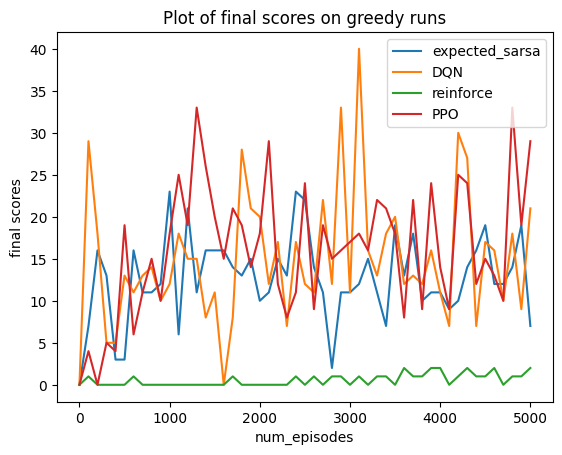

In [43]:
fig = plt.figure()
plt.plot(x_list, small_esarsa_score_list, label="expected_sarsa")
plt.plot(x_list, small_dqn_score_list, label="DQN")
plt.plot(x_list, small_reinf_score_list, label="reinforce")
plt.plot(x_list, small_ppo_score_list, label="PPO")
plt.xlabel("num_episodes")
plt.ylabel("final scores")
plt.legend()
plt.title("Plot of final scores on greedy runs")
plt.show()

Sarsa :
mean : 12.647058823529411
std : 5.001268581861241
DQN :
mean : 14.92156862745098
std : 7.773366135003529
REINFORCE :
mean : 0.5686274509803921
std : 0.6932419423397524
PPO :
mean : 16.137254901960784
std : 7.7206613753149345


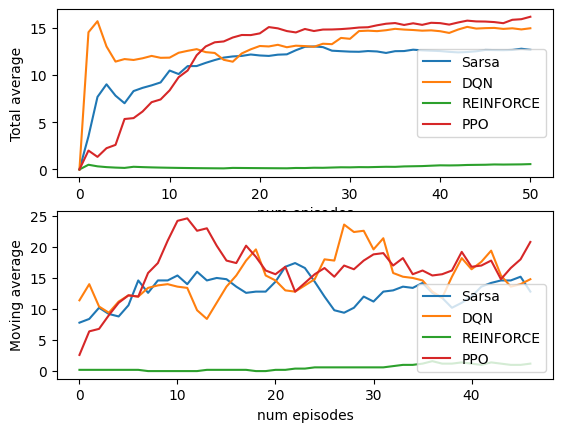

In [44]:
import numpy as np

small_res={'Sarsa' : small_esarsa_score_list, 'DQN' : small_dqn_score_list , 'REINFORCE' : small_reinf_score_list, 'PPO' : small_ppo_score_list}

for k in small_res.keys():
    print(k + ' :')
    print("mean : "+str(np.mean(small_res[k])))
    print("std : "+str(np.std(small_res[k])))
    

fig,axs=plt.subplots(2)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

for key in small_res.keys():
    axs[0].plot(np.cumsum(small_res[key])/(np.arange(len(small_res[key]))+1),label = key)
    axs[1].plot(moving_average(small_res[key],5),label = key)

    
axs[0].set_ylabel('Total average')
axs[1].set_ylabel('Moving average')

for i in [0,1]:
    axs[i].set_xlabel("num episodes")
    axs[i].legend()

# Larger Screen Comparison

In [45]:
from text_snake_simple import TextSnakeEnvSimple

large_env = TextSnakeEnvSimple(screen_size=(20, 15), colab=True)    
num_runs = 50
x_list = list(range(num_runs+1))
for i, elem in enumerate(x_list):
    x_list[i] = elem*100

In [46]:
from exp_sarsa_functions.exp_sarsa_utils import create_state_dict, run_episode
from exp_sarsa_functions.exp_sarsa_ag import ExpectedSarsaAgent
from dqn_functions.dqn_trainer import QTrainer
from policy_estimator_functions.policy_estimator import policy_estimator, reinforce, make_greedy_run
from stable_baselines3 import PPO

state_dict = create_state_dict(n_bools=11)
agent_info = {"num_actions": 3, "num_states": len(state_dict), "EPS_START": 0.9, "EPS_END": 0.05, 
            "EPS_DECAY": 5000, "step_size": 0.8, "discount": 0.99, "seed": 0}
large_esarsa_agent = ExpectedSarsaAgent()
large_esarsa_agent.agent_init(agent_info)
large_esarsa_score_list = [0]
num_episodes = 1000
for run in tqdm.tqdm(range(num_runs//10)):
    steps_done = 0
    for episode in tqdm.tqdm(range(num_episodes)):
        if episode+1 == num_episodes and run+1 == num_runs//10: 
            steps_done, converged, score = run_episode(large_env, large_esarsa_agent, episode, state_dict, steps_done, False, True)
            large_esarsa_score_list.append(score)
        elif (episode+1)%100 == 0:
            steps_done, converged, score = run_episode(large_env, large_esarsa_agent, episode, state_dict, steps_done, False, False)
            large_esarsa_score_list.append(score)
        else: 
            steps_done, converged, _ = run_episode(large_env, large_esarsa_agent, episode, state_dict, steps_done, True, False)

large_qtrainer = QTrainer()
large_dqn_score_list = [0]
for j in tqdm.tqdm(range(num_runs)):
    large_qtrainer.train(large_env, 100)
    obs, info = large_env.reset()
    done = False
    n_steps = 0
    while not done and n_steps < 5000:
        prediction = large_qtrainer.model(torch.tensor(obs, dtype=torch.float))
        action = large_qtrainer.argmax(prediction).item()
        obs, reward, done, _, info = large_env.step(action)
        n_steps += 1
        if j+1 == num_runs:
            large_env.render() 
        if done:
            break
    large_dqn_score_list.append(info["score"])
    large_env.close()

state, info = large_env.reset()
large_reinf_score_list = [0]
large_neural_agent = policy_estimator(11, 3)    
large_optimizer = optim.Adam(large_neural_agent.network.parameters(), lr=0.0001)
render = False 
for j in tqdm.tqdm(range(num_runs)): 
    num_episodes = 100
    total_rewards, converged = reinforce(large_env, large_neural_agent, large_optimizer, num_episodes=num_episodes)
    if j+1 == num_runs:
        render = True
    converged, score = make_greedy_run(large_env, large_neural_agent, render)
    large_reinf_score_list.append(score)
    large_env.close()

large_policy_kwargs = dict(activation_fn=nn.ReLU,
                net_arch=dict(pi=[256, 256], vf=[256, 256]))
large_model = PPO("MlpPolicy", large_env, policy_kwargs=large_policy_kwargs, ent_coef=0.01)
large_ppo_score_list = [0]
for j in tqdm.tqdm(range(num_runs)):
    large_model.learn(total_timesteps=100)
    large_vec_env = large_model.get_env() 
    obs = large_vec_env.reset()
    done = False 
    n_step = 0
    while not done and n_step < 5000: 
        action, _state = large_model.predict(obs, deterministic=True)
        obs, reward, done, info = large_vec_env.step(action)
        if j+1 == num_runs:
            large_env.render()
        n_step += 1
        if done: 
            break
    large_ppo_score_list.append(info[0]["score"])

Text Snake!
Score: 0
---------------------
[                   ]
[                   ]
[                   ]
[                   ]
[                   ]
[                   ]
[       --o         ]
[                   ]
[           @       ]
[                   ]
[                   ]
[                   ]
[                   ]
[                   ]
^^^^^^^^^^^^^^^^^^^^^
Game initialized!

100%|██████████| 50/50 [06:31<00:00,  7.84s/it]


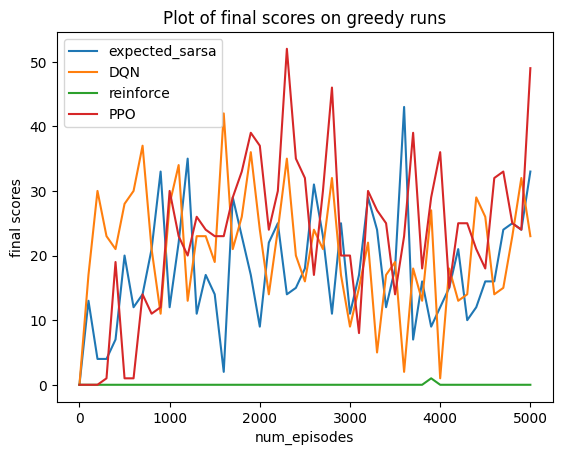

In [47]:
fig = plt.figure()
plt.plot(x_list, large_esarsa_score_list, label="expected_sarsa")
plt.plot(x_list, large_dqn_score_list, label="DQN")
plt.plot(x_list, large_reinf_score_list, label="reinforce")
plt.plot(x_list, large_ppo_score_list, label="PPO")
plt.xlabel("num_episodes")
plt.ylabel("final scores")
plt.legend()
plt.title("Plot of final scores on greedy runs")
plt.show()

Sarsa :
mean : 17.58823529411765
std : 8.854325342902756
DQN :
mean : 20.88235294117647
std : 9.074089505069958
REINFORCE :
mean : 0.0196078431372549
std : 0.1386483884679505
PPO :
mean : 23.294117647058822
std : 12.227090009638689


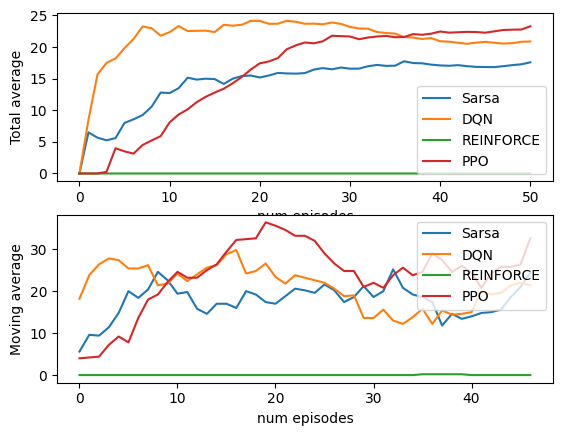

In [48]:
large_res={'Sarsa' : large_esarsa_score_list, 'DQN' : large_dqn_score_list , 'REINFORCE' : large_reinf_score_list, 'PPO' : large_ppo_score_list}

for k in large_res.keys():
    print(k + ' :')
    print("mean : "+str(np.mean(large_res[k])))
    print("std : "+str(np.std(large_res[k])))
    

fig,axs=plt.subplots(2)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

for key in small_res.keys():
    axs[0].plot(np.cumsum(large_res[key])/(np.arange(len(large_res[key]))+1),label = key)
    axs[1].plot(moving_average(large_res[key],5),label = key)

    
axs[0].set_ylabel('Total average')
axs[1].set_ylabel('Moving average')

for i in [0,1]:
    axs[i].set_xlabel("num episodes")
    axs[i].legend()